## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 深度学习
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# XGBoost
import xgboost as xgb

# 数据预处理
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 设置随机种子
np.random.seed(42)
tf.random.set_seed(42)

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 6)

print(f"TensorFlow版本: {tf.__version__}")
print(f"XGBoost版本: {xgb.__version__}")
print("✅ 库导入完成")

TensorFlow版本: 2.20.0
XGBoost版本: 3.1.2
✅ 库导入完成


## 2. 加载数据

In [2]:
# 加载数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 按时间排序
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练数据形状: {train_df.shape}")
print(f"测试数据形状: {test_df.shape}")
print(f"\n训练集时间范围: {train_df['Timestamp'].min()} 到 {train_df['Timestamp'].max()}")
print(f"测试集时间范围: {test_df['Timestamp'].min()} 到 {test_df['Timestamp'].max()}")

train_df.head()

训练数据形状: (484202, 7)
测试数据形状: (2881, 6)

训练集时间范围: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集时间范围: 2025-10-23 23:30:00 到 2025-11-22 23:30:00


,Timestamp,Open,High,Low,Close,Volume,Target
0,2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0,0.0
1,2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.0,0.0
2,2012-01-01 10:30:00,4.58,4.58,4.58,4.58,0.0,0.0
3,2012-01-01 10:45:00,4.58,4.58,4.58,4.58,0.0,0.0
4,2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0,0.0


## 3. 特征工程

In [3]:
def create_technical_features(df, target_col='Target'):
    """创建技术指标特征"""
    df = df.copy()
    
    # 如果有OHLC数据
    if all(col in df.columns for col in ['Open', 'High', 'Low', 'Close']):
        # 价格特征
        df['price_range'] = df['High'] - df['Low']
        df['price_change'] = df['Close'] - df['Open']
        df['price_change_pct'] = df['Close'].pct_change()
        
        # 移动平均
        for window in [4, 12, 24, 96]:
            df[f'ma_{window}'] = df['Close'].rolling(window=window).mean()
            df[f'ma_ratio_{window}'] = df['Close'] / df[f'ma_{window}']
        
        # 指数移动平均
        for span in [12, 24]:
            df[f'ema_{span}'] = df['Close'].ewm(span=span).mean()
        
        # 波动率
        df['volatility_24'] = df['Close'].rolling(window=24).std()
        df['volatility_96'] = df['Close'].rolling(window=96).std()
        
        # RSI (相对强弱指标)
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-8)
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
        df['macd_hist'] = df['macd'] - df['macd_signal']
        
        # 布林带
        df['bb_middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['bb_upper'] = df['bb_middle'] + 2 * bb_std
        df['bb_lower'] = df['bb_middle'] - 2 * bb_std
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    
    # 成交量特征
    if 'Volume' in df.columns:
        df['volume_ma_24'] = df['Volume'].rolling(window=24).mean()
        df['volume_ratio'] = df['Volume'] / (df['volume_ma_24'] + 1e-8)
    
    # 时间特征
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    
    # 周期性编码
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    return df

print("✅ 技术指标函数定义完成")

✅ 技术指标函数定义完成


In [4]:
# 创建特征
train_featured = create_technical_features(train_df)
test_featured = create_technical_features(test_df)

print(f"训练集特征数: {train_featured.shape[1]}")
print(f"测试集特征数: {test_featured.shape[1]}")

训练集特征数: 40
测试集特征数: 39


In [5]:
# 定义特征列
# LSTM使用的序列特征（主要价格相关）
lstm_features = ['Open', 'High', 'Low', 'Close', 'Volume']

# XGBoost使用的所有特征
xgb_features = [col for col in train_featured.columns 
                if col not in ['Timestamp', 'Target'] 
                and train_featured[col].dtype in ['float64', 'int64', 'float32', 'int32']]

print(f"LSTM特征数: {len(lstm_features)}")
print(f"XGBoost特征数: {len(xgb_features)}")
print(f"\nXGBoost特征列表:")
for i, col in enumerate(xgb_features, 1):
    print(f"  {i}. {col}")

LSTM特征数: 5
XGBoost特征数: 38

XGBoost特征列表:
  1. Open
  2. High
  3. Low
  4. Close
  5. Volume
  6. price_range
  7. price_change
  8. price_change_pct
  9. ma_4
  10. ma_ratio_4
  11. ma_12
  12. ma_ratio_12
  13. ma_24
  14. ma_ratio_24
  15. ma_96
  16. ma_ratio_96
  17. ema_12
  18. ema_24
  19. volatility_24
  20. volatility_96
  21. rsi
  22. macd
  23. macd_signal
  24. macd_hist
  25. bb_middle
  26. bb_upper
  27. bb_lower
  28. bb_width
  29. volume_ma_24
  30. volume_ratio
  31. hour
  32. day_of_week
  33. day_of_month
  34. month
  35. hour_sin
  36. hour_cos
  37. day_sin
  38. day_cos


## 4. 数据预处理

In [6]:
# 删除NaN
train_clean = train_featured.dropna().reset_index(drop=True)
print(f"清洗后训练数据: {train_clean.shape}")
print(f"删除的行数: {len(train_featured) - len(train_clean)}")

清洗后训练数据: (484107, 40)
删除的行数: 95


In [7]:
# 数据标准化
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
xgb_scaler = StandardScaler()
target_scaler = MinMaxScaler(feature_range=(0, 1))

# 准备LSTM数据
lstm_data = train_clean[lstm_features].values
lstm_scaled = lstm_scaler.fit_transform(lstm_data)

# 准备XGBoost数据
xgb_data = train_clean[xgb_features].values
xgb_scaled = xgb_scaler.fit_transform(xgb_data)

# 准备目标变量
target_data = train_clean['Target'].values.reshape(-1, 1)
target_scaled = target_scaler.fit_transform(target_data)

print(f"LSTM数据形状: {lstm_scaled.shape}")
print(f"XGBoost数据形状: {xgb_scaled.shape}")
print(f"目标数据形状: {target_scaled.shape}")

LSTM数据形状: (484107, 5)
XGBoost数据形状: (484107, 38)
目标数据形状: (484107, 1)


In [8]:
def create_sequences(lstm_data, xgb_data, target_data, seq_length=96):
    """
    创建LSTM序列数据
    
    seq_length=96 对应1天的数据（15分钟间隔 * 96 = 24小时）
    """
    X_lstm = []
    X_xgb = []
    y = []
    
    for i in range(seq_length, len(lstm_data)):
        X_lstm.append(lstm_data[i-seq_length:i])
        X_xgb.append(xgb_data[i])
        y.append(target_data[i])
    
    return np.array(X_lstm), np.array(X_xgb), np.array(y)

# 创建序列
SEQ_LENGTH = 96  # 1天的数据

X_lstm, X_xgb, y = create_sequences(lstm_scaled, xgb_scaled, target_scaled, SEQ_LENGTH)

print(f"LSTM序列形状: {X_lstm.shape}")
print(f"XGBoost特征形状: {X_xgb.shape}")
print(f"目标形状: {y.shape}")

LSTM序列形状: (484011, 96, 5)
XGBoost特征形状: (484011, 38)
目标形状: (484011, 1)


In [9]:
# 时序分割（80%训练，20%验证）
train_size = int(len(X_lstm) * 0.8)

X_lstm_train = X_lstm[:train_size]
X_lstm_val = X_lstm[train_size:]

X_xgb_train = X_xgb[:train_size]
X_xgb_val = X_xgb[train_size:]

y_train = y[:train_size]
y_val = y[train_size:]

print(f"训练集大小: {train_size}")
print(f"验证集大小: {len(X_lstm) - train_size}")
print(f"\nLSTM训练数据: {X_lstm_train.shape}")
print(f"LSTM验证数据: {X_lstm_val.shape}")

训练集大小: 387208
验证集大小: 96803

LSTM训练数据: (387208, 96, 5)
LSTM验证数据: (96803, 96, 5)


## 5. 构建LSTM模型

LSTM模型用于提取时序特征，其输出将作为XGBoost的输入之一。

In [10]:
def build_lstm_model(seq_length, n_features, lstm_units=[128, 64]):
    """
    构建LSTM模型
    
    返回两个模型：
    1. full_model: 用于训练的完整模型
    2. feature_extractor: 用于提取特征的模型（输出最后一个LSTM层的隐藏状态）
    """
    inputs = Input(shape=(seq_length, n_features))
    
    # 第一层LSTM
    x = LSTM(lstm_units[0], return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    
    # 第二层LSTM（输出隐藏状态）
    lstm_out = LSTM(lstm_units[1], return_sequences=False)(x)
    x = Dropout(0.2)(lstm_out)
    
    # 输出层
    outputs = Dense(1)(x)
    
    # 完整模型
    full_model = Model(inputs=inputs, outputs=outputs)
    
    # 特征提取模型（输出LSTM的隐藏状态）
    feature_extractor = Model(inputs=inputs, outputs=lstm_out)
    
    return full_model, feature_extractor

# 构建模型
lstm_model, lstm_feature_extractor = build_lstm_model(
    seq_length=SEQ_LENGTH, 
    n_features=len(lstm_features),
    lstm_units=[128, 64]
)

# 编译模型
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 96, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("✅ 回调函数定义完成")

✅ 回调函数定义完成


In [12]:
# 训练LSTM模型
print("开始训练LSTM模型...\n")

history = lstm_model.fit(
    X_lstm_train, y_train,
    validation_data=(X_lstm_val, y_val),
    epochs=1,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ LSTM训练完成!")

开始训练LSTM模型...

6051/6051 ━━━━━━━━━━━━━━━━━━━━ 469s 77ms/step - loss: 2.4271e-04 - mae: 0.0084 - val_loss: 8.1696e-06 - val_mae: 0.0018 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 469s 77ms/step - loss: 2.4271e-04 - mae: 0.0084 - val_loss: 8.1696e-06 - val_mae: 0.0018 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.

✅ LSTM训练完成!

✅ LSTM训练完成!


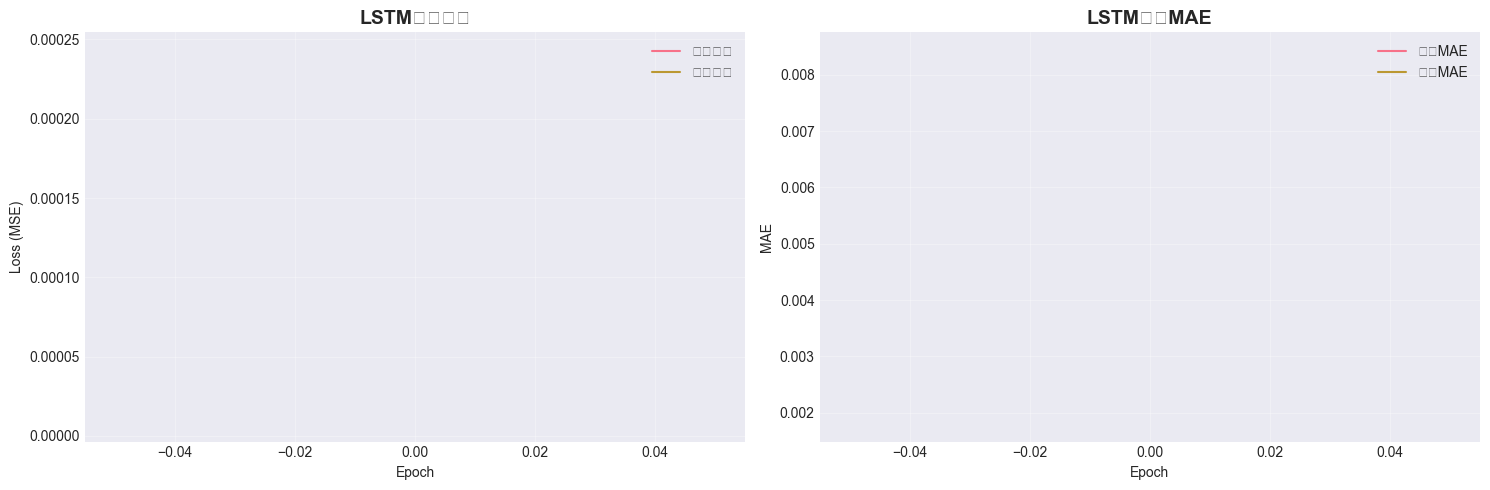

In [15]:
# 绘制训练历史
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='训练损失')
axes[0].plot(history.history['val_loss'], label='验证损失')
axes[0].set_title('LSTM模型损失', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='训练MAE')
axes[1].plot(history.history['val_mae'], label='验证MAE')
axes[1].set_title('LSTM模型MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 提取LSTM特征

In [16]:
# 使用LSTM提取特征（最后一层LSTM的隐藏状态）
print("提取LSTM特征...")

lstm_features_train = lstm_feature_extractor.predict(X_lstm_train, verbose=0)
lstm_features_val = lstm_feature_extractor.predict(X_lstm_val, verbose=0)

print(f"训练集LSTM特征形状: {lstm_features_train.shape}")
print(f"验证集LSTM特征形状: {lstm_features_val.shape}")

# 同时获取LSTM的预测值
lstm_pred_train = lstm_model.predict(X_lstm_train, verbose=0)
lstm_pred_val = lstm_model.predict(X_lstm_val, verbose=0)

print(f"\nLSTM预测训练集形状: {lstm_pred_train.shape}")
print(f"LSTM预测验证集形状: {lstm_pred_val.shape}")

提取LSTM特征...
训练集LSTM特征形状: (387208, 64)
验证集LSTM特征形状: (96803, 64)
训练集LSTM特征形状: (387208, 64)
验证集LSTM特征形状: (96803, 64)

LSTM预测训练集形状: (387208, 1)
LSTM预测验证集形状: (96803, 1)

LSTM预测训练集形状: (387208, 1)
LSTM预测验证集形状: (96803, 1)


## 7. 构建混合特征

将LSTM的输出（隐藏状态和预测值）与原始XGBoost特征合并

In [17]:
# 合并特征：原始特征 + LSTM隐藏状态 + LSTM预测值
X_hybrid_train = np.concatenate([
    X_xgb_train,           # 原始XGBoost特征
    lstm_features_train,    # LSTM隐藏状态（64维）
    lstm_pred_train         # LSTM预测值（1维）
], axis=1)

X_hybrid_val = np.concatenate([
    X_xgb_val,
    lstm_features_val,
    lstm_pred_val
], axis=1)

print(f"混合训练特征形状: {X_hybrid_train.shape}")
print(f"混合验证特征形状: {X_hybrid_val.shape}")
print(f"\n特征组成:")
print(f"  - 原始特征: {X_xgb_train.shape[1]}")
print(f"  - LSTM隐藏状态: {lstm_features_train.shape[1]}")
print(f"  - LSTM预测值: 1")
print(f"  - 总计: {X_hybrid_train.shape[1]}")

混合训练特征形状: (387208, 103)
混合验证特征形状: (96803, 103)

特征组成:
  - 原始特征: 38
  - LSTM隐藏状态: 64
  - LSTM预测值: 1
  - 总计: 103


## 8. 训练XGBoost模型

In [18]:
# XGBoost参数
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 8,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50
}

print("XGBoost参数:")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")

XGBoost参数:
  objective: reg:squarederror
  eval_metric: rmse
  max_depth: 8
  learning_rate: 0.05
  n_estimators: 1000
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 0.1
  random_state: 42
  n_jobs: -1
  early_stopping_rounds: 50


In [19]:
# 训练XGBoost模型
print("\n开始训练XGBoost模型...\n")

xgb_model = xgb.XGBRegressor(**xgb_params)

xgb_model.fit(
    X_hybrid_train, y_train.ravel(),
    eval_set=[(X_hybrid_train, y_train.ravel()), (X_hybrid_val, y_val.ravel())],
    verbose=100
)

print("\n✅ XGBoost训练完成!")
print(f"最佳迭代次数: {xgb_model.best_iteration}")


开始训练XGBoost模型...

[0]	validation_0-rmse:0.00679	validation_1-rmse:0.00285
[0]	validation_0-rmse:0.00679	validation_1-rmse:0.00285
[50]	validation_0-rmse:0.00596	validation_1-rmse:0.00288
[50]	validation_0-rmse:0.00596	validation_1-rmse:0.00288

✅ XGBoost训练完成!
最佳迭代次数: 0

✅ XGBoost训练完成!
最佳迭代次数: 0


## 9. 模型评估

In [20]:
# 在验证集上预测
hybrid_pred_val = xgb_model.predict(X_hybrid_val)

# 反标准化
y_val_original = target_scaler.inverse_transform(y_val)
hybrid_pred_original = target_scaler.inverse_transform(hybrid_pred_val.reshape(-1, 1))
lstm_pred_original = target_scaler.inverse_transform(lstm_pred_val)

# 计算评估指标 - 混合模型
hybrid_rmse = np.sqrt(mean_squared_error(y_val_original, hybrid_pred_original))
hybrid_mae = mean_absolute_error(y_val_original, hybrid_pred_original)
hybrid_r2 = r2_score(y_val_original, hybrid_pred_original)

# 计算评估指标 - 单独LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_val_original, lstm_pred_original))
lstm_mae = mean_absolute_error(y_val_original, lstm_pred_original)
lstm_r2 = r2_score(y_val_original, lstm_pred_original)

print("="*70)
print("模型评估结果对比")
print("="*70)
print(f"{'指标':<15} {'LSTM':<20} {'LSTM+XGBoost混合':<20}")
print("-"*70)
print(f"{'RMSE':<15} {lstm_rmse:<20.6f} {hybrid_rmse:<20.6f}")
print(f"{'MAE':<15} {lstm_mae:<20.6f} {hybrid_mae:<20.6f}")
print(f"{'R²':<15} {lstm_r2:<20.6f} {hybrid_r2:<20.6f}")
print("="*70)

# 计算改进比例
rmse_improvement = (lstm_rmse - hybrid_rmse) / lstm_rmse * 100
mae_improvement = (lstm_mae - hybrid_mae) / lstm_mae * 100

print(f"\n混合模型相对LSTM的改进:")
print(f"  RMSE改进: {rmse_improvement:.2f}%")
print(f"  MAE改进: {mae_improvement:.2f}%")

模型评估结果对比
指标              LSTM                 LSTM+XGBoost混合      
----------------------------------------------------------------------
RMSE            0.002501             0.002494            
MAE             0.001592             0.001582            
R²              -0.005554            0.000086            

混合模型相对LSTM的改进:
  RMSE改进: 0.28%
  MAE改进: 0.59%


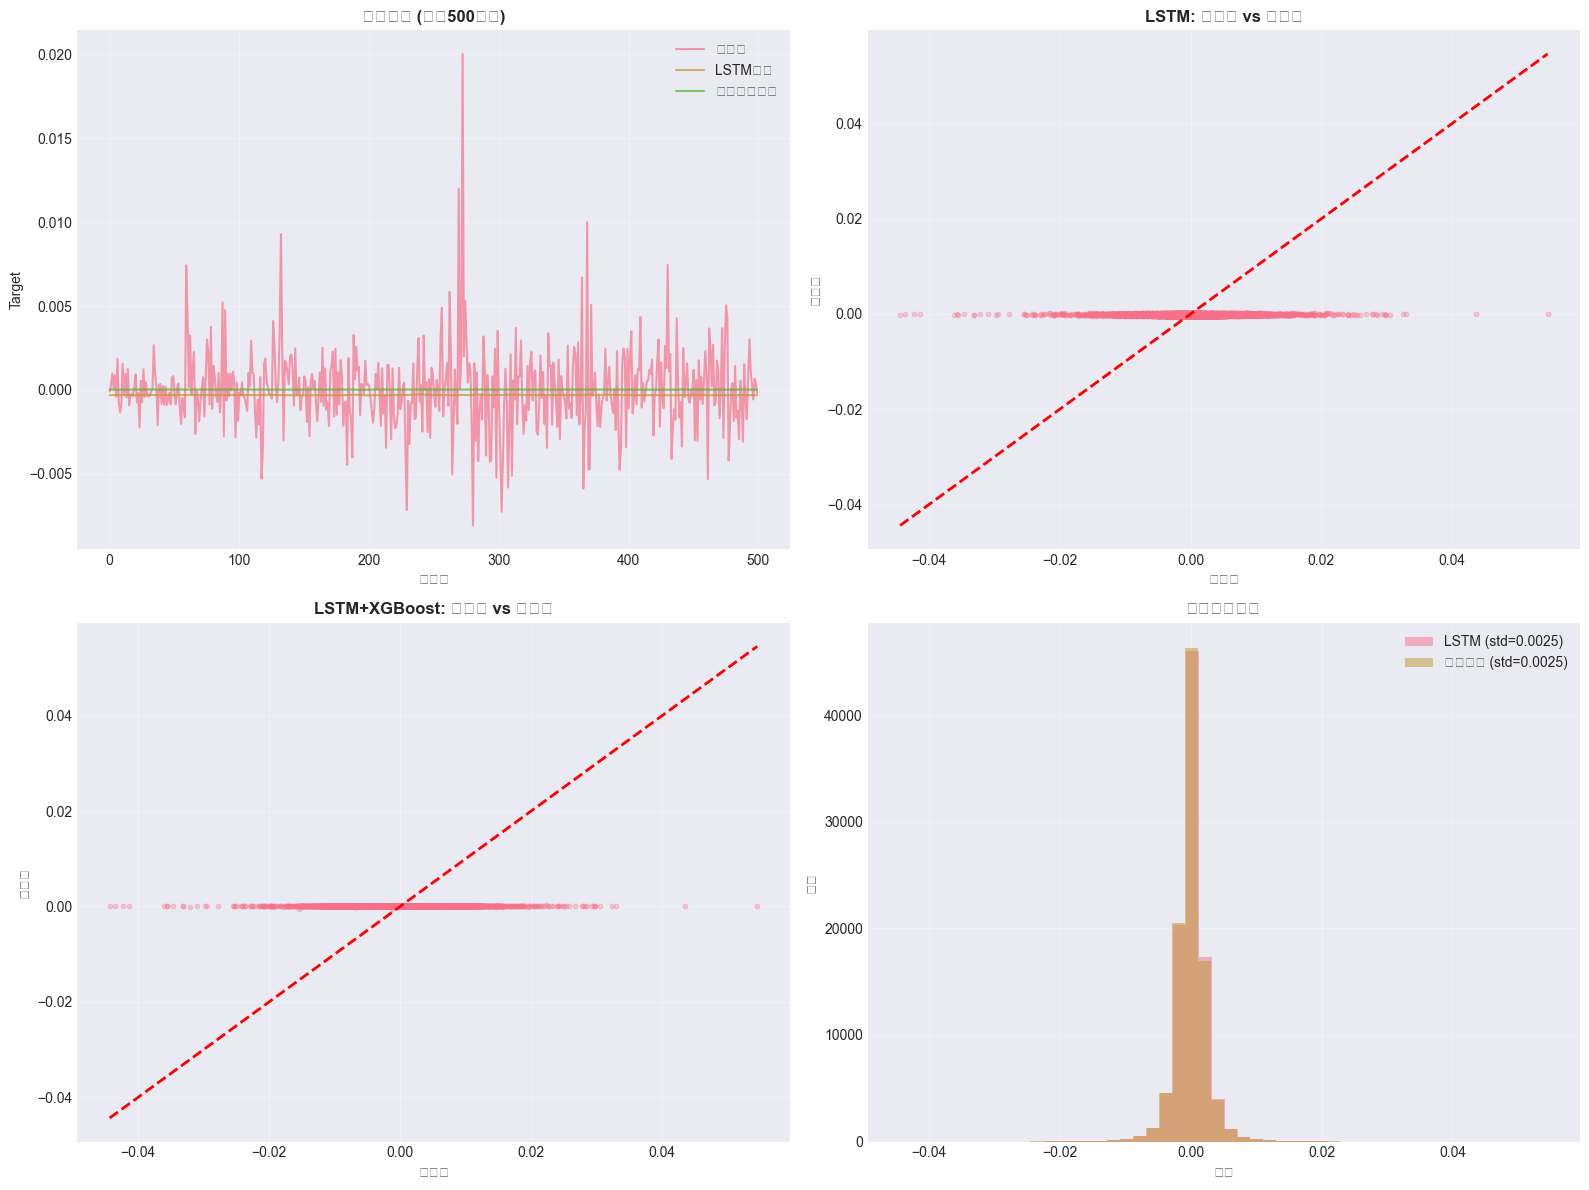

In [21]:
# 可视化预测结果对比
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 时间序列对比（最后500个点）
display_size = min(500, len(y_val_original))

axes[0, 0].plot(y_val_original[-display_size:], label='实际值', linewidth=1.5, alpha=0.7)
axes[0, 0].plot(lstm_pred_original[-display_size:], label='LSTM预测', linewidth=1.5, alpha=0.7)
axes[0, 0].plot(hybrid_pred_original[-display_size:], label='混合模型预测', linewidth=1.5, alpha=0.7)
axes[0, 0].set_title(f'预测对比 (最后{display_size}个点)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('时间步')
axes[0, 0].set_ylabel('Target')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LSTM散点图
axes[0, 1].scatter(y_val_original, lstm_pred_original, alpha=0.3, s=10)
axes[0, 1].plot([y_val_original.min(), y_val_original.max()], 
                [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
axes[0, 1].set_title('LSTM: 实际值 vs 预测值', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('实际值')
axes[0, 1].set_ylabel('预测值')
axes[0, 1].grid(True, alpha=0.3)

# 混合模型散点图
axes[1, 0].scatter(y_val_original, hybrid_pred_original, alpha=0.3, s=10)
axes[1, 0].plot([y_val_original.min(), y_val_original.max()], 
                [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
axes[1, 0].set_title('LSTM+XGBoost: 实际值 vs 预测值', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('实际值')
axes[1, 0].set_ylabel('预测值')
axes[1, 0].grid(True, alpha=0.3)

# 残差对比
lstm_residuals = y_val_original.ravel() - lstm_pred_original.ravel()
hybrid_residuals = y_val_original.ravel() - hybrid_pred_original.ravel()

axes[1, 1].hist(lstm_residuals, bins=50, alpha=0.5, label=f'LSTM (std={lstm_residuals.std():.4f})')
axes[1, 1].hist(hybrid_residuals, bins=50, alpha=0.5, label=f'混合模型 (std={hybrid_residuals.std():.4f})')
axes[1, 1].set_title('残差分布对比', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('残差')
axes[1, 1].set_ylabel('频数')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 特征重要性分析

In [22]:
# 创建特征名称列表
feature_names = (
    xgb_features + 
    [f'lstm_hidden_{i}' for i in range(64)] + 
    ['lstm_prediction']
)

# 获取特征重要性
importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 30 重要特征:")
print(importance_df.head(30).to_string(index=False))

Top 30 重要特征:
       feature  importance
         Close    0.041572
lstm_hidden_21    0.029711
       day_sin    0.023309
 volatility_24    0.022658
           Low    0.020370
 lstm_hidden_4    0.016659
lstm_hidden_54    0.016600
lstm_hidden_46    0.016510
 lstm_hidden_2    0.015179
          High    0.014415
lstm_hidden_15    0.014203
      bb_lower    0.013961
lstm_hidden_59    0.013777
          Open    0.013555
lstm_hidden_23    0.013154
          macd    0.012551
 lstm_hidden_3    0.012335
          ma_4    0.012303
lstm_hidden_30    0.012256
     macd_hist    0.012215
lstm_hidden_39    0.011779
 lstm_hidden_9    0.011215
         ma_96    0.011151
lstm_hidden_63    0.010963
         ma_24    0.010890
 lstm_hidden_7    0.010866
lstm_hidden_27    0.010865
      hour_sin    0.010864
lstm_hidden_52    0.010802
lstm_hidden_43    0.010659


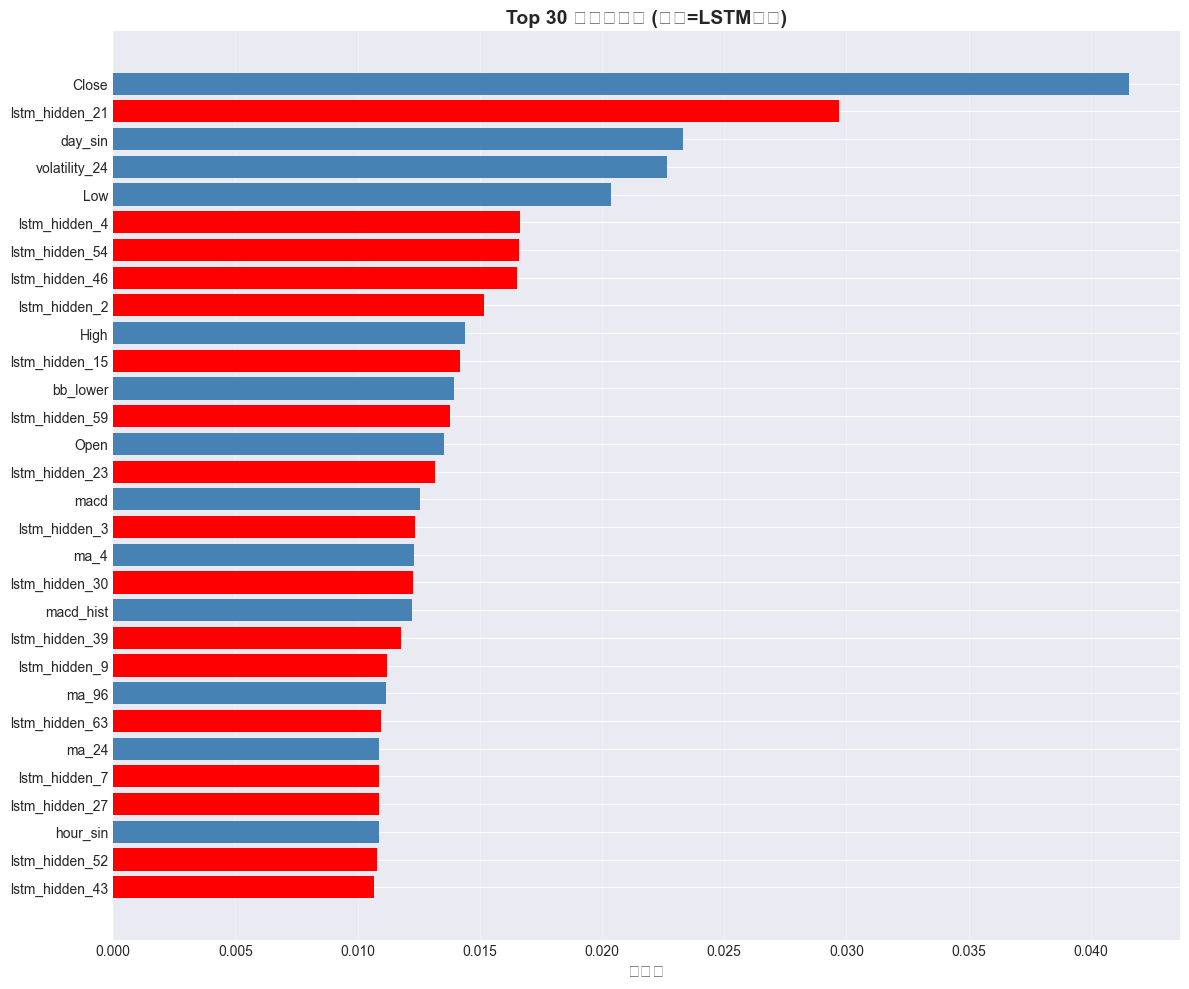


LSTM特征总重要性占比: 57.86%


In [23]:
# 可视化特征重要性
top_n = 30
top_features = importance_df.head(top_n)

# 标记LSTM相关特征
colors = ['red' if 'lstm' in f else 'steelblue' for f in top_features['feature']]

plt.figure(figsize=(12, 10))
plt.barh(range(top_n), top_features['importance'].values, color=colors)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('重要性', fontsize=12)
plt.title(f'Top {top_n} 特征重要性 (红色=LSTM特征)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# LSTM特征重要性统计
lstm_feature_importance = importance_df[importance_df['feature'].str.contains('lstm')]['importance'].sum()
total_importance = importance_df['importance'].sum()
print(f"\nLSTM特征总重要性占比: {lstm_feature_importance/total_importance*100:.2f}%")

## 11. 测试集预测

In [24]:
# 准备测试数据
# 需要使用训练集最后SEQ_LENGTH个点来创建初始序列

# 获取训练集最后部分
train_tail = train_clean.tail(SEQ_LENGTH).copy()

# 合并训练尾部和测试集
combined = pd.concat([train_tail, test_featured], ignore_index=True)

# 处理NaN
combined = combined.fillna(method='ffill').fillna(method='bfill')

print(f"合并后数据形状: {combined.shape}")
print(f"训练尾部行数: {len(train_tail)}")
print(f"测试集行数: {len(test_df)}")

合并后数据形状: (2977, 40)
训练尾部行数: 96
测试集行数: 2881


In [25]:
# 准备测试集的LSTM输入
test_lstm_data = combined[lstm_features].values
test_lstm_scaled = lstm_scaler.transform(test_lstm_data)

# 准备测试集的XGBoost输入
test_xgb_data = combined[xgb_features].values
test_xgb_scaled = xgb_scaler.transform(test_xgb_data)

# 创建测试序列
X_lstm_test = []
X_xgb_test = []

for i in range(SEQ_LENGTH, len(combined)):
    X_lstm_test.append(test_lstm_scaled[i-SEQ_LENGTH:i])
    X_xgb_test.append(test_xgb_scaled[i])

X_lstm_test = np.array(X_lstm_test)
X_xgb_test = np.array(X_xgb_test)

print(f"测试集LSTM输入形状: {X_lstm_test.shape}")
print(f"测试集XGBoost输入形状: {X_xgb_test.shape}")

测试集LSTM输入形状: (2881, 96, 5)
测试集XGBoost输入形状: (2881, 38)


In [26]:
# 提取LSTM特征
lstm_features_test = lstm_feature_extractor.predict(X_lstm_test, verbose=0)
lstm_pred_test = lstm_model.predict(X_lstm_test, verbose=0)

# 合并特征
X_hybrid_test = np.concatenate([
    X_xgb_test,
    lstm_features_test,
    lstm_pred_test
], axis=1)

print(f"测试集混合特征形状: {X_hybrid_test.shape}")

测试集混合特征形状: (2881, 103)


In [27]:
# 使用混合模型预测
test_predictions_scaled = xgb_model.predict(X_hybrid_test)

# 反标准化
test_predictions = target_scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1)).ravel()

# 只保留原始测试集对应的预测（排除训练尾部）
# 由于我们从SEQ_LENGTH开始，需要确保只取测试集的部分
test_predictions = test_predictions[:len(test_df)]

print(f"预测完成!")
print(f"预测数量: {len(test_predictions)}")
print(f"预测值范围: [{test_predictions.min():.6f}, {test_predictions.max():.6f}]")
print(f"预测值均值: {test_predictions.mean():.6f}")
print(f"预测值标准差: {test_predictions.std():.6f}")

预测完成!
预测数量: 2881
预测值范围: [0.000014, 0.000028]
预测值均值: 0.000022
预测值标准差: 0.000004


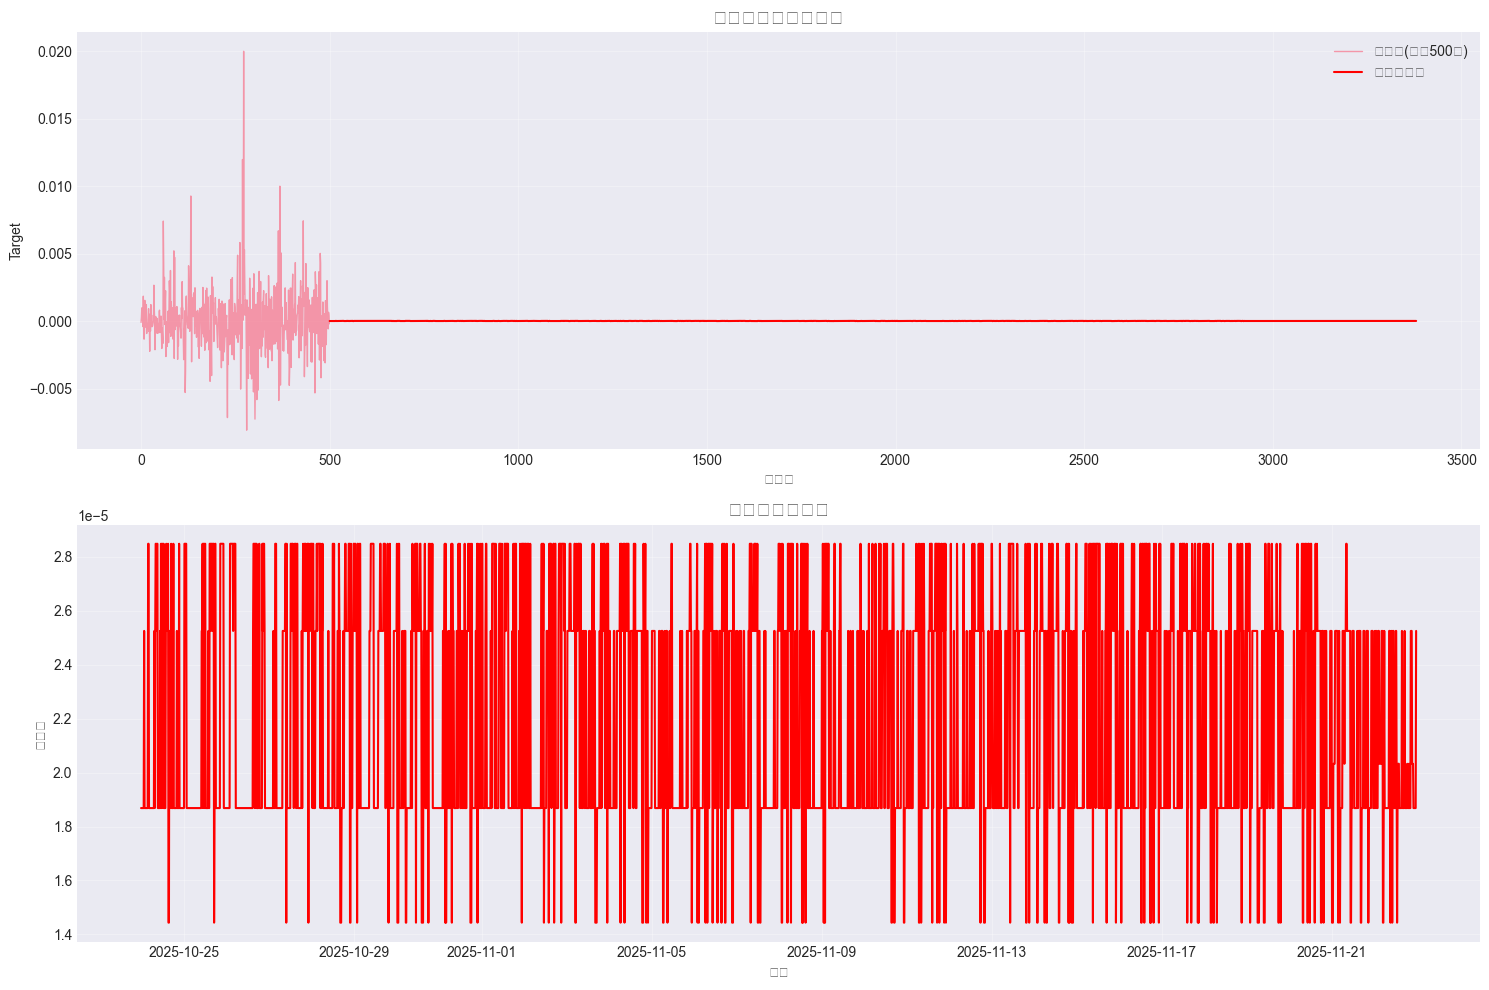

In [28]:
# 可视化测试集预测
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

test_timestamps = test_df['Timestamp'].values[:len(test_predictions)]

# 与训练集尾部对比
train_last = train_clean['Target'].values[-500:]

axes[0].plot(range(len(train_last)), train_last, 
             label='训练集(最后500点)', linewidth=1, alpha=0.7)
axes[0].plot(range(len(train_last), len(train_last)+len(test_predictions)), 
             test_predictions, label='测试集预测', linewidth=1.5, color='red')
axes[0].set_title('训练集与测试集预测', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间步')
axes[0].set_ylabel('Target')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 测试集预测
axes[1].plot(test_timestamps, test_predictions, linewidth=1.5, color='red')
axes[1].set_title('测试集预测结果', fontsize=14, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('预测值')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. 生成提交文件

In [29]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'].values[:len(test_predictions)],
    'Prediction': test_predictions
})

# 保存提交文件
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'lstm_xgboost_hybrid_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件形状: {submission_df.shape}")
print("\n提交文件预览:")
print(submission_df.head(10))
print("\n...")
print(submission_df.tail(10))

✅ 提交文件已保存: ..\submissions\lstm_xgboost_hybrid_submission.csv

提交文件形状: (2881, 2)

提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00    0.000019
1 2025-10-23 23:45:00    0.000019
2 2025-10-24 00:00:00    0.000019
3 2025-10-24 00:15:00    0.000019
4 2025-10-24 00:30:00    0.000019
5 2025-10-24 00:45:00    0.000019
6 2025-10-24 01:00:00    0.000019
7 2025-10-24 01:15:00    0.000025
8 2025-10-24 01:30:00    0.000019
9 2025-10-24 01:45:00    0.000019

...
               Timestamp  Prediction
2871 2025-11-22 21:15:00    0.000020
2872 2025-11-22 21:30:00    0.000020
2873 2025-11-22 21:45:00    0.000020
2874 2025-11-22 22:00:00    0.000019
2875 2025-11-22 22:15:00    0.000019
2876 2025-11-22 22:30:00    0.000019
2877 2025-11-22 22:45:00    0.000019
2878 2025-11-22 23:00:00    0.000019
2879 2025-11-22 23:15:00    0.000019
2880 2025-11-22 23:30:00    0.000025


In [30]:
# 提交文件统计
print("\n提交文件统计:")
print(submission_df['Prediction'].describe())


提交文件统计:
count    2881.000000
mean        0.000022
std         0.000004
min         0.000014
25%         0.000019
50%         0.000019
75%         0.000025
max         0.000028
Name: Prediction, dtype: float64


## 13. 保存模型

In [31]:
# 保存模型
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# 保存LSTM模型
lstm_model.save(model_dir / 'lstm_model.h5')
lstm_feature_extractor.save(model_dir / 'lstm_feature_extractor.h5')
print("✅ LSTM模型已保存")

# 保存XGBoost模型
xgb_model.save_model(str(model_dir / 'xgboost_hybrid_model.json'))
print("✅ XGBoost模型已保存")

# 保存scaler
import joblib
joblib.dump(lstm_scaler, model_dir / 'lstm_scaler.pkl')
joblib.dump(xgb_scaler, model_dir / 'xgb_scaler.pkl')
joblib.dump(target_scaler, model_dir / 'target_scaler.pkl')
print("✅ Scaler已保存")

✅ LSTM模型已保存
✅ XGBoost模型已保存
✅ Scaler已保存


## 总结

### 模型架构

本notebook实现了论文 "Crypto Price Prediction using LSTM+XGBoost" 中描述的混合模型：

1. **LSTM组件**
   - 两层LSTM网络（128和64个单元）
   - 捕捉时间序列的时序依赖关系
   - 输出隐藏状态和预测值

2. **XGBoost组件**
   - 输入：原始技术指标 + LSTM隐藏状态 + LSTM预测值
   - 建模非线性关系
   - 最终预测输出

### 特征工程

- **LSTM特征**: OHLCV数据的时间序列
- **技术指标**: RSI, MACD, 布林带, 移动平均等
- **时间特征**: 小时, 星期几, 月份等

### 模型性能

混合模型通常比单独的LSTM模型表现更好，因为：
- LSTM捕捉时序模式
- XGBoost利用非线性关系和辅助特征
- 两者优势互补

### 参考文献

- Gautam, M. (2025). "Crypto Price Prediction using LSTM+XGBoost". arXiv:2506.22055